# ReRank

## Setup

In [1]:
import os
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv()) # read local .env file

In [25]:
import cohere
co = cohere.Client("f25TSVZu9ltUtKteb1wmeKRPeSyaAUIEJ91LMa5a")

Start by imporing Weaviate to access the Wikipedia database

In [2]:
import weaviate
auth_config = weaviate.auth.AuthApiKey(
    api_key="76320a90-53d8-42bc-b41d-678647c6672e")

# 76320a90-53d8-42bc-b41d-678647c6672e

C:\Users\bouchekir\Anaconda3\envs\AssARG\lib\site-packages\google\protobuf\runtime_version.py:112: UserWarning: Protobuf gencode version 5.27.2 is older than the runtime version 5.28.0 at grpc_health/v1/health.proto. Please avoid checked-in Protobuf gencode that can be obsolete.
  warnings.warn(


In [8]:
client = weaviate.Client(
    url="https://cohere-demo.weaviate.network/",
    auth_client_secret=auth_config,
    additional_headers={
        "X-Cohere-Api-Key": "f25TSVZu9ltUtKteb1wmeKRPeSyaAUIEJ91LMa5a"
    }
)
client.is_ready()

True

 ## Utils

In [9]:

def keyword_search(query, 
                   client,
                   results_lang='en', 
                   properties = ["text", "title", "url", "views", "lang", "_additional {distance}"],
                   num_results=3):

    where_filter = {
    "path": ["lang"],
    "operator": "Equal",
    "valueString": results_lang
    }

    response = (
        client.query.get("Articles", properties)
        .with_bm25(
          query=query
        )
        .with_where(where_filter)
        .with_limit(num_results)
        .do()
        )
    result = response['data']['Get']['Articles']
    return result


def dense_retrieval(query, 
                    client,
                    results_lang='en', 
                    properties = ["text", "title", "url", "views", "lang", "_additional {distance}"],
                    num_results=5):

    nearText = {"concepts": [query]}
    
    # To filter by language
    where_filter = {
    "path": ["lang"],
    "operator": "Equal",
    "valueString": results_lang
    }
    response = (
        client.query
        .get("Articles", properties)
        .with_near_text(nearText)
        .with_where(where_filter)
        .with_limit(num_results)
        .do()
    )

    result = response['data']['Get']['Articles']

    return result


def print_result(result):
    """ Print results with colorful formatting """
    for i,item in enumerate(result):
        print(f'item {i}')
        for key in item.keys():
            print(f"{key}:{item.get(key)}")
            print()
        print()

## Dense Retrieval

In [16]:
query = "What is the capital of Canada?"

In [17]:
dense_retrieval_results = dense_retrieval(query, client)

In [18]:
print_result(dense_retrieval_results)

item 0
_additional:{'distance': -150.8031}

lang:en

text:The governor general of the province had designated Kingston as the capital in 1841. However, the major population centres of Toronto and Montreal, as well as the former capital of Lower Canada, Quebec City, all had legislators dissatisfied with Kingston. Anglophone merchants in Quebec were the main group supportive of the Kingston arrangement. In 1842, a vote rejected Kingston as the capital, and study of potential candidates included the then-named Bytown, but that option proved less popular than Toronto or Montreal. In 1843, a report of the Executive Council recommended Montreal as the capital as a more fortifiable location and commercial centre, however, the Governor General refused to execute a move without a parliamentary vote. In 1844, the Queen's acceptance of a parliamentary vote moved the capital to Montreal.

title:Ottawa

url:https://en.wikipedia.org/wiki?curid=22219

views:2000


item 1
_additional:{'distance': -150

problem: it retreive "title:Quebec City" which is wrong


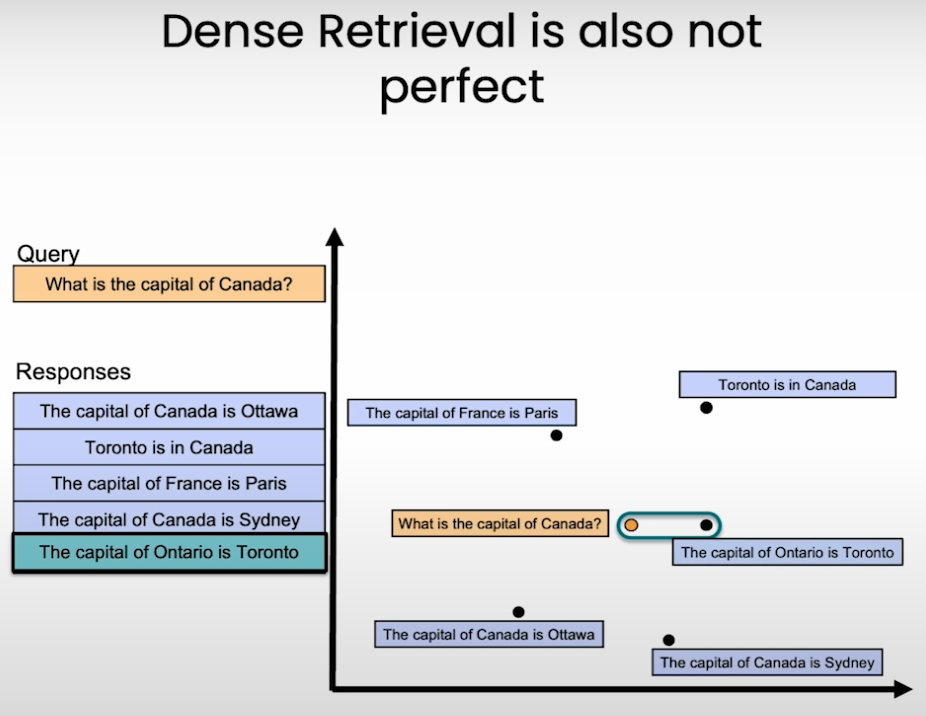

ReRanking can be a solution 

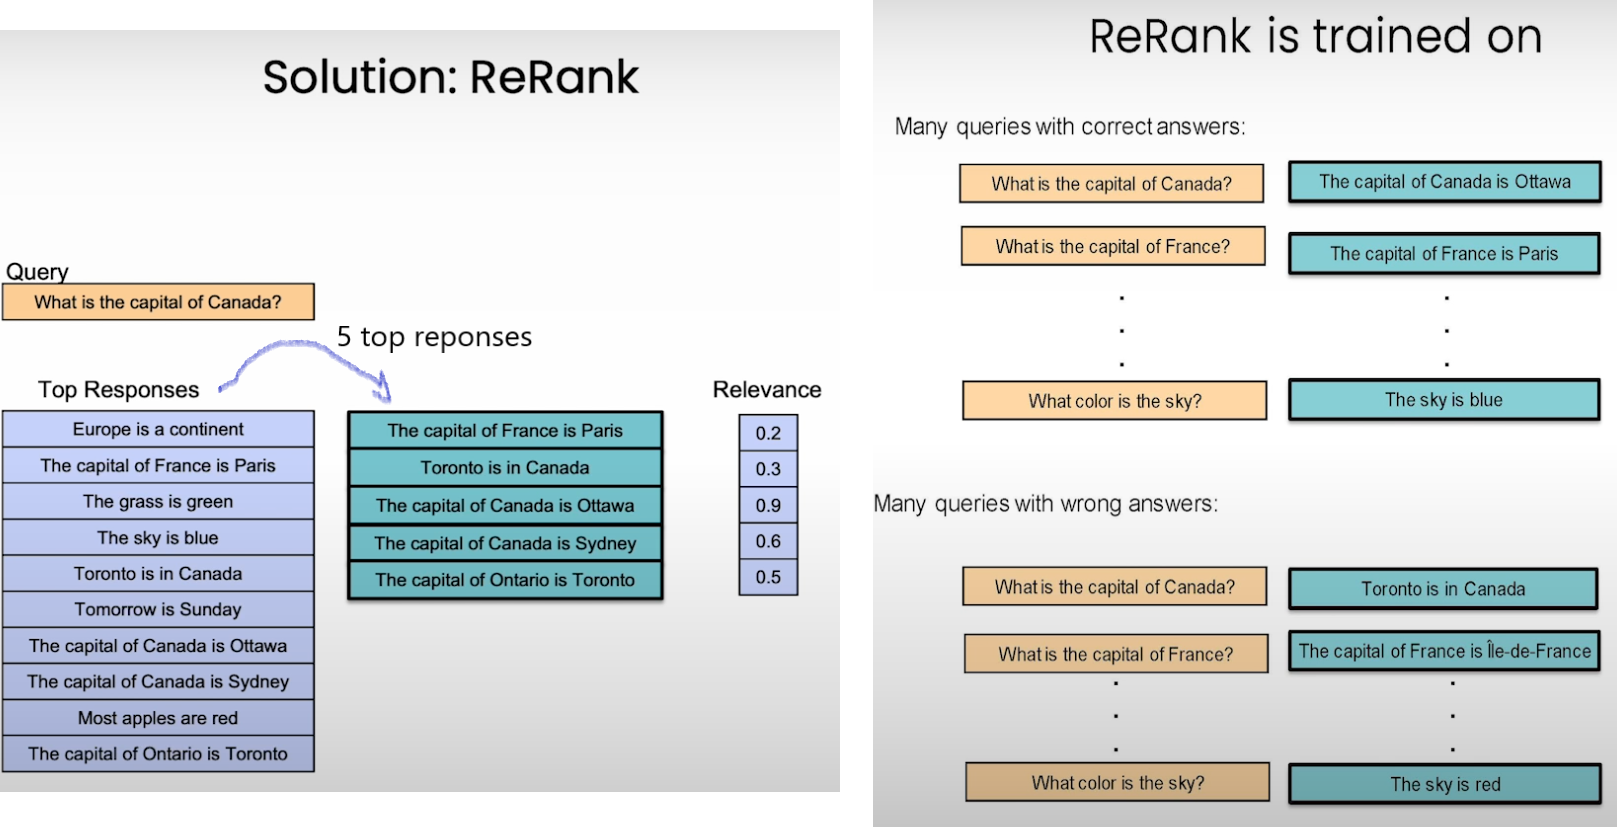

In [19]:
query_1 = "What is the capital of Canada?"

In [20]:
results = keyword_search(query_1,
                         client,
                         properties=["text", "title", "url", "views", "lang", "_additional {distance}"],
                         num_results=3
                        )

for i, result in enumerate(results):
    print(f"i:{i}")
    print(result.get('title'))
    print(result.get('text'))

i:0
Monarchy of Canada
In his 1990 book, "Continental Divide: the Values and Institutions of the United States and Canada," Seymour Martin Lipset argues that the presence of the monarchy in Canada helps distinguish Canadian identity from American identity. Since at least the 1930s, supporters of the Crown have held the opinion that the Canadian monarch is also one of the rare unified elements of Canadian society, focusing both "the historic consciousness of the nation" and various forms of patriotism and national love "[on] the point around which coheres the nation's sense of a continuing personality". Former Governor General Vincent Massey articulated in 1967 that the monarchy "is part of ourselves. It is linked in a very special way with our national life. It stands for qualities and institutions which mean Canada to every one of us and which for all our differences and all our variety have kept Canada Canadian." But, according to Arthur Bousfield and Gary Toffoli, Canadians were, th

In [21]:
query_1 = "What is the capital of Canada?"
results = keyword_search(query_1,
                         client,
                         properties=["text", "title", "url", "views", "lang", "_additional {distance}"],
                         num_results=500
                        )

for i, result in enumerate(results):
    print(f"i:{i}")
    print(result.get('title'))
    #print(result.get('text'))

i:0
Monarchy of Canada
i:1
Early modern period
i:2
Flag of Canada
i:3
Flag of Canada
i:4
Prime Minister of Canada
i:5
Hamilton, Ontario
i:6
Liberal Party of Canada
i:7
Stephen Harper
i:8
Monarchy of Canada
i:9
Flag of Canada
i:10
Order of Canada
i:11
University of Toronto
i:12
Newfoundland (island)
i:13
Liberal Party of Canada
i:14
Newfoundland (island)
i:15
Flag of Canada
i:16
North American Free Trade Agreement
i:17
Pea
i:18
Monarchy of Canada
i:19
Prime Minister of Canada
i:20
Hamilton, Ontario
i:21
Aesop's Fables
i:22
Revolutions of 1989
i:23
R.S.C. Anderlecht
i:24
Hudson's Bay Company
i:25
Liberal Party of Canada
i:26
2020–21 NBA season
i:27
Filibuster
i:28
Hardcore punk
i:29
Early modern period
i:30
Skopje
i:31
Venture capital
i:32
Wakanda
i:33
Arjuna
i:34
Luhansk
i:35
Arlington National Cemetery
i:36
North American Free Trade Agreement
i:37
Global North and Global South
i:38
Shia–Sunni relations
i:39
Jacob Zuma
i:40
Early modern period
i:41
Maui
i:42
Gerhard Schröder
i:43
Revolu

In [22]:
def rerank_responses(query, responses, num_responses=10):
    reranked_responses = co.rerank(
        model = 'rerank-english-v2.0',
        query = query,
        documents = responses,
        top_n = num_responses,
        )
    return reranked_responses

In [26]:
texts = [result.get('text') for result in results]
reranked_text = rerank_responses(query_1, texts)

In [27]:
for i, rerank_result in enumerate(reranked_text):
    print(f"i:{i}")
    print(f"{rerank_result}")
    print()

i:0
('id', 'e67ba50d-83c1-4644-9797-7b5e4bbf833e')

i:1
('results', [RerankResponseResultsItem(document=None, index=407, relevance_score=0.9875684), RerankResponseResultsItem(document=None, index=100, relevance_score=0.9795897), RerankResponseResultsItem(document=None, index=202, relevance_score=0.9753901), RerankResponseResultsItem(document=None, index=496, relevance_score=0.9711838), RerankResponseResultsItem(document=None, index=479, relevance_score=0.96653706), RerankResponseResultsItem(document=None, index=481, relevance_score=0.9421884), RerankResponseResultsItem(document=None, index=68, relevance_score=0.86567897), RerankResponseResultsItem(document=None, index=394, relevance_score=0.86153823), RerankResponseResultsItem(document=None, index=228, relevance_score=0.4989891), RerankResponseResultsItem(document=None, index=5, relevance_score=0.49455282)])

i:2
('meta', ApiMeta(api_version=ApiMetaApiVersion(version='1', is_deprecated=None, is_experimental=None), billed_units=ApiMetaB

## Improving Dense Retrieval with ReRank

In [29]:
query_2 = "Who is the tallest person in history?"

In [30]:
results = dense_retrieval(query_2,client)

In [31]:
for i, result in enumerate(results):
    print(f"i:{i}")
    print(result.get('title'))
    print(result.get('text'))
    print()

i:0
Robert Wadlow
Robert Pershing Wadlow (February 22, 1918 July 15, 1940), also known as the Alton Giant and the Giant of Illinois, was a man who was the tallest person in recorded history for whom there is irrefutable evidence. He was born and raised in Alton, Illinois, a small city near St. Louis, Missouri.

i:1
Manute Bol
Bol came from a family of extraordinarily tall men and women. He said: "My mother was , my father , and my sister is . And my great-grandfather was even taller—." His ethnic group, the Dinka, and the Nilotic people of which they are a part, are among the tallest populations in the world. Bol's hometown, Turalei, is the origin of other exceptionally tall people, including basketball player Ring Ayuel. "I was born in a village, where you cannot measure yourself," Bol reflected. "I learned I was 7 foot 7 in 1979, when I was grown. I was about 18 or 19."

i:2
Sultan Kösen
Sultan Kösen (born 10 December 1982) is a Turkish farmer who holds the Guinness World Record for 

In [32]:
texts = [result.get('text') for result in results]
reranked_text = rerank_responses(query_2, texts)

In [33]:
for i, rerank_result in enumerate(reranked_text):
    print(f"i:{i}")
    print(f"{rerank_result}")
    print()

i:0
('id', 'a7cfc634-d53f-44c9-906d-a9e5b625c666')

i:1
('results', [RerankResponseResultsItem(document=None, index=0, relevance_score=0.9734939), RerankResponseResultsItem(document=None, index=2, relevance_score=0.8664718), RerankResponseResultsItem(document=None, index=4, relevance_score=0.80162543), RerankResponseResultsItem(document=None, index=3, relevance_score=0.6874202), RerankResponseResultsItem(document=None, index=1, relevance_score=0.6396235)])

i:2
('meta', ApiMeta(api_version=ApiMetaApiVersion(version='1', is_deprecated=None, is_experimental=None), billed_units=ApiMetaBilledUnits(input_tokens=None, output_tokens=None, search_units=1.0, classifications=None), tokens=None, warnings=None))



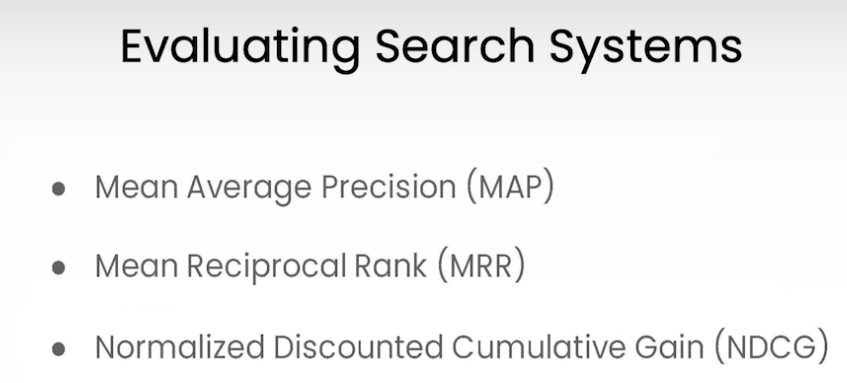